In [1]:
'''  
@Author: Sharday Olowu
@Date: 03/05/2022

@Sources:
◉ Multivariate time series forecasting - built upon sample of work from: 
https://colab.research.google.com/drive/1b3CUJuDOmPmNdZFH3LQDmt5F0K3FZhqD?usp=sharing
Work author: Greg Hogg 

Modifications:
- extended to allow user to change forecast length via ADVANCE_STEPS
- visualisation of simulation output file network measurements and handovers
- pre-processing steps to combine all simulation output into one dataframe, recording file positions within dataframe
- forming windows and labels from individual time series within large dataframe
- altered LSTM model architecture for required dimensions for multi-variate time series forecasting
- scaled data via StandardScaler function from sklearn
- automatic train/validation/test split of 80/10/10 with any dataset
- extension of plot_predictions to rescale and visualise RSRP-1 and RSRP-2
- calculation of RMSE and MAE on the test set

◉ Learned how to train an XGBoost model for classification and calculate performance metrics during online course - Machine Learning A-Z (Udemy):
https://www.udemy.com/course/machinelearning/learn/lecture/6087180#overview

◉ Hyperparameter grid search - adapted from:
https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost/notebook
Work author: 'Tilii: https://kaggle.com/tilii7' 

Modifications:
- increaed number of stratified folds to increase reliablility
- modified to work with the current data
- code simplification

◉ ROC curve and AUC calculation - adapted from:
https://python-bloggers.com/2020/12/roc-and-auc-how-to-evaluate-machine-learning-models-in-no-time/
Work author: Dario Radečić 

Modifications: 
- pre-processing of current data 
- code simplification
- improved ROC graph visualisation

'''

"  \n@Author: Sharday Olowu\n@Date: 03/05/2022\n\n@Sources:\n◉ Multivariate time series forecasting - built upon sample of work from: \nhttps://colab.research.google.com/drive/1b3CUJuDOmPmNdZFH3LQDmt5F0K3FZhqD?usp=sharing\nWork author: Greg Hogg \n\nModifications:\n-extended to allow user to change forecast length via ADVANCE_STEPS\n-visualisation of simulation output file network measurements and handovers\n-pre-processing steps to combine all simulation output into one dataframe, recording file positions within dataframe\n-forming windows and labels from individual time series within large dataframe\n-altered LSTM model architecture for required dimensions for multi-variate time series forecasting\n-scaled data via StandardScaler function from sklearn\n-automatic train/validation/test split of 80/10/10 with any dataset\n-extension of plot_predictions to rescale and visualise RSRP-1 and RSRP-2\n-calculation of RMSE and MAE on the test set\n\n◉ Learned how to train an XGBoost model for

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
plt.rcParams.update({'font.size': 22})

In [3]:
#set random seed for reproducible results
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

# View a simulation output file

In [4]:
df = pd.read_csv('C:/Users/shard/Documents/workspace/sim_outputs/0.txt') # example simulation output file

# ensure RSRP and RSRQ values are negative
df["RSRP_eNB_1"] = -df["RSRP_eNB_1"] 
df["RSRP_eNB_2"] = -df["RSRP_eNB_2"] 
df["RSRQ_eNB_1"] = -df["RSRQ_eNB_1"] 
df["RSRQ_eNB_2"] = -df["RSRQ_eNB_2"] 
df

,time,x,y,RSRP_eNB_1,RSRP_eNB_2,RSRQ_eNB_1,RSRQ_eNB_2,S-PCI,Unnamed: 8
0,0.680001,770.82,194.76,-82,-78,-30,-23,1,NaN
1,1.160000,753.78,218.50,-82,-82,-27,-27,1,NaN
2,1.640000,771.86,188.56,-84,-83,-28,-26,1,NaN
3,2.120000,708.86,250.48,-84,-81,-30,-24,1,NaN
4,2.600000,712.90,250.68,-85,-82,-29,-25,1,NaN
...,...,...,...,...,...,...,...,...,...
2176,997.680000,731.10,196.14,-89,-80,-32,-14,1,NaN
2177,998.160000,692.10,194.10,-89,-81,-32,-16,1,NaN
2178,998.640000,733.04,200.52,-93,-80,-33,-6,1,NaN
2179,999.120000,755.12,233.16,-88,-81,-31,-18,1,NaN


## Network measurement variations

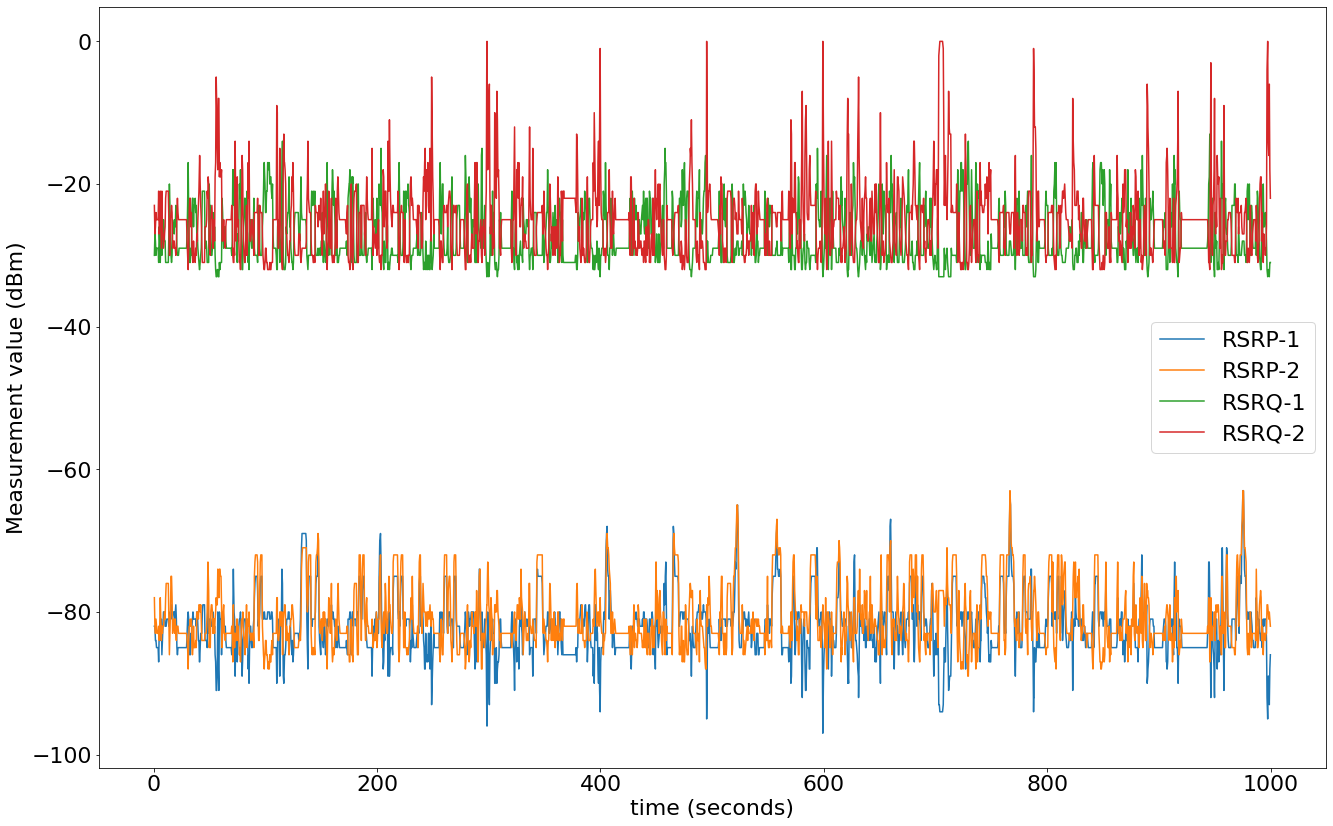

In [5]:
plt.rcParams["figure.figsize"] = (22, 14)
RSRP1 = df.iloc[:,3].values
RSRP2 = df.iloc[:,4].values
RSRQ1 = df.iloc[:,5].values
RSRQ2 = df.iloc[:,6].values
time = df.iloc[:,0].values
S_PCI = df.iloc[:,7].values

plt.plot(time, RSRP1, label='RSRP-1')
plt.plot(time, RSRP2, label='RSRP-2')
plt.plot(time, RSRQ1, label='RSRQ-1')
plt.plot(time, RSRQ2, label='RSRQ-2')

plt.xlabel('time (seconds)')
plt.ylabel('Measurement value (dBm)')
plt.legend(loc='center right')
plt.show()

## Handovers

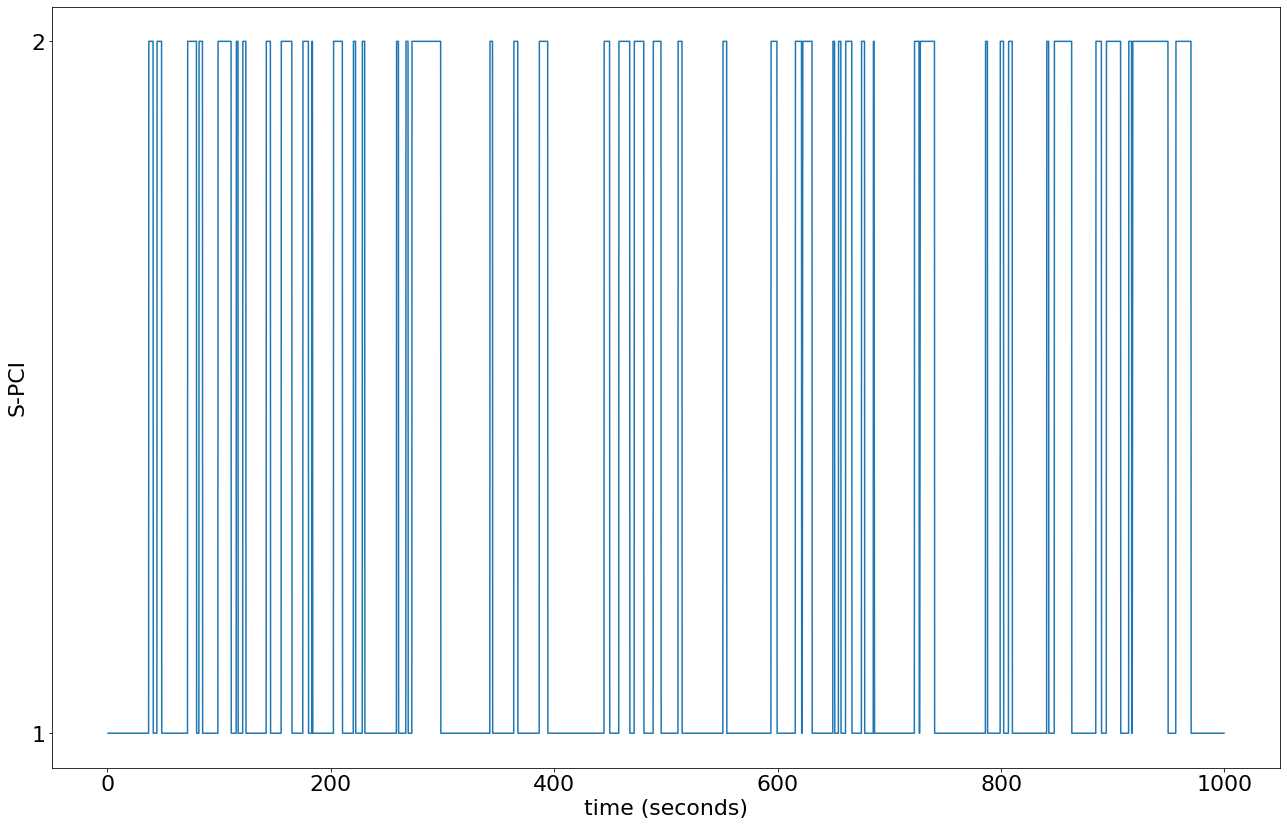

In [38]:
plt.xlabel('time (seconds)')
plt.ylabel('S-PCI')
plt.yticks(np.arange(3))
plt.plot(time, S_PCI, label='S_PCI')
plt.show()

# LSTM - multivariate time series forecasting

## Data pre-processing

In [7]:

def df_to_X_y(df, advance, window_size):
  X = []
  y = []
  for i in range(len(df)-window_size-advance):
    row = [r for r in df[i:i+window_size]]
    X.append(row)
    label = [df[i+window_size+advance][0], df[i+window_size+advance][1]]
    y.append(label)
  return np.array(X), np.array(y)

In [8]:
WINDOW_SIZE = 5
ADVANCE_STEPS = 1 #can be adjusted to change forecast length


dfs = []



fileEndPoints = []

#read 100 simulation output files
for i in range(100):
    
    dfc = pd.read_csv('C:/Users/shard/Documents/workspace/sim_outputs/' + str(i) + '.txt')
    # make RSRP and RSRQ values negative
    dfc["RSRP_eNB_1"] = -dfc["RSRP_eNB_1"] 
    dfc["RSRP_eNB_2"] = -dfc["RSRP_eNB_2"] 
    dfc["RSRQ_eNB_1"] = -dfc["RSRQ_eNB_1"] 
    dfc["RSRQ_eNB_2"] = -dfc["RSRQ_eNB_2"] 
    
    
    # record positions of files
    
    if len(fileEndPoints) > 0:
        lastStart = fileEndPoints[-1]
    else:
        lastStart = 0
    
    fileEndPoints.append(lastStart + len(dfc))
    
    #select relevant columns
    cols = list(dfc)[3:8]
    train_df = dfc[cols]
    dfs.append(train_df)
    

#concatenate all dataframes into one large dataframe containing all simulation output
frame = pd.concat(dfs, axis=0, ignore_index=True)


SPCI_labels = frame.iloc[:,-1].values
frame = frame.iloc[:,:-1].astype(float)



In [9]:
#scale data

scaler = StandardScaler()
scaler = scaler.fit(frame)
train_df_scaled = scaler.transform(frame)
train_df_scaled

array([[-0.13985109,  0.62097194, -0.65740407,  0.30550339],
       [-0.13985109, -0.14413255, -0.23751654, -0.28740782],
       [-0.57994174, -0.33540868, -0.37747905, -0.13918002],
       ...,
       [-2.120259  ,  0.23841969, -0.93732908,  1.93600922],
       [-1.68016836,  0.42969582, -1.07729159,  1.78778142],
       [-1.68016836,  0.42969582, -1.07729159,  1.78778142]])

In [10]:
numFiles = 10
startPoint = 0

X2, y2 = np.empty((0, 5, 4)), np.empty((0, 2))
totalWindows = 0

#convert simulation output into windows and labels

for i in range(len(fileEndPoints)):

    current_df = train_df_scaled[startPoint:fileEndPoints[i]]
    
    X, y = df_to_X_y(current_df, ADVANCE_STEPS-1, WINDOW_SIZE)

    numWindows = len(y)
    if numWindows < 1:
        continue
    totalWindows += numWindows

    X2 = np.concatenate((X2,X), axis=0)
    y2 = np.concatenate((y2,y), axis=0)
    startPoint += fileEndPoints[i] - startPoint
    

X2.shape, y2.shape


((209052, 5, 4), (209052, 2))

In [11]:

import math

# split into training, validation and testing sets

endTrain = math.floor(0.8 * X2.shape[0])
endVal = math.floor(0.9 * X2.shape[0])

X2_train, y2_train = X2[:endTrain], y2[:endTrain]
X2_val, y2_val = X2[endTrain:endVal], y2[endTrain:endVal]
X2_test, y2_test = X2[endVal:], y2[endVal:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((167241, 5, 4),
 (167241, 2),
 (20905, 5, 4),
 (20905, 2),
 (20906, 5, 4),
 (20906, 2))

## Training - RSRP-1 & RSRP-2 forecasting

In [12]:
def build_model():
    model = Sequential()
    model.add(InputLayer((5, 4)))
    model.add(LSTM(64))
    model.add(Dense(8, 'relu'))
    model.add(Dense(2, 'linear'))

    return model

In [13]:
model2 = build_model()
model2.summary()
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                17664     
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 18        
Total params: 18,202
Trainable params: 18,202
Non-trainable params: 0
_________________________________________________________________


In [14]:
history2 = model2.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=50, callbacks=[cp2])

Epoch 1/50
5212/5227 [============================>.] - ETA: 0s - loss: 0.3378 - root_mean_squared_error: 0.5812WARNING:tensorflow:From C:\Users\shard\anaconda3\envs\irp\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model2\assets
5227/5227 [==============================] - 12s 2ms/step - loss: 0.3376 - root_mean_squared_error: 0.5810 - val_loss: 0.2849 - val_root_mean_squared_error: 0.5338
Epoch 2/50
5227/5227 [==============================] - 12s 2ms/step - loss: 0.2384 - root_mean_squared_error: 0.4883 - val_loss: 0.2790 - val_root_mean_squared_error: 0.5282
Epoch 3/50
5227

Epoch 27/50
5227/5227 [==============================] - 8s 2ms/step - loss: 0.2211 - root_mean_squared_error: 0.4702 - val_loss: 0.2636 - val_root_mean_squared_error: 0.5134
Epoch 28/50
5227/5227 [==============================] - 12s 2ms/step - loss: 0.2208 - root_mean_squared_error: 0.4699 - val_loss: 0.2617 - val_root_mean_squared_error: 0.5116
Epoch 29/50
5227/5227 [==============================] - 8s 1ms/step - loss: 0.2205 - root_mean_squared_error: 0.4696 - val_loss: 0.2640 - val_root_mean_squared_error: 0.5138
Epoch 30/50
5227/5227 [==============================] - 13s 2ms/step - loss: 0.2201 - root_mean_squared_error: 0.4692 - val_loss: 0.2610 - val_root_mean_squared_error: 0.5108
Epoch 31/50
5227/5227 [==============================] - 8s 1ms/step - loss: 0.2200 - root_mean_squared_error: 0.4691 - val_loss: 0.2614 - val_root_mean_squared_error: 0.5113
Epoch 32/50
5227/5227 [==============================] - 8s 1ms/step - loss: 0.2197 - root_mean_squared_error: 0.4687 - val

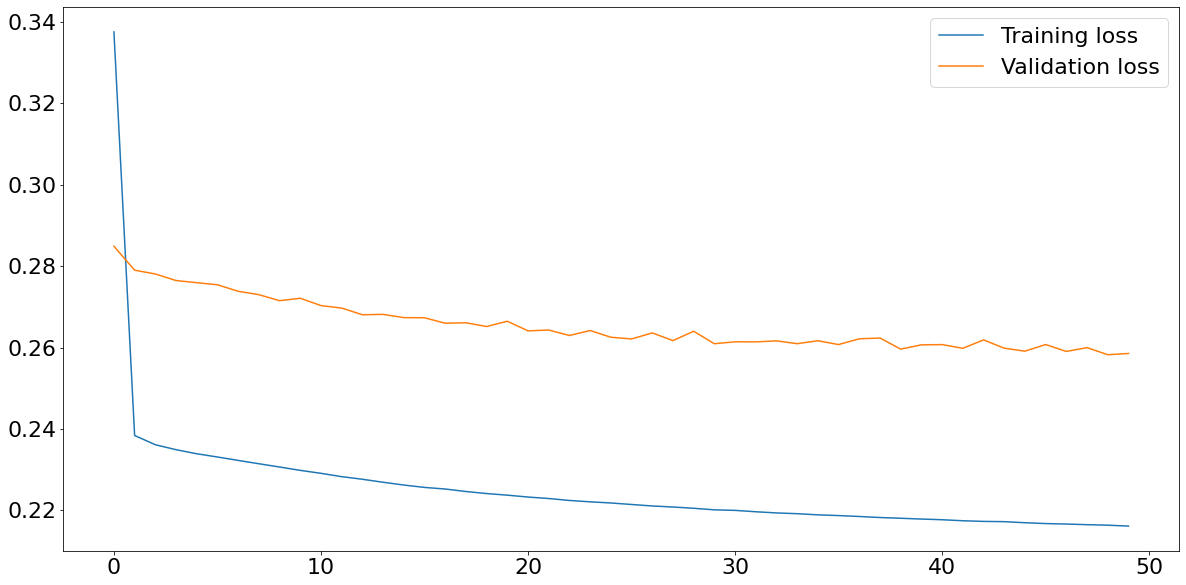

In [15]:
plt.rcParams["figure.figsize"] = (20, 10)
plt.plot(history2.history['loss'], label='Training loss')
plt.plot(history2.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

## Visualisation of test set sample

In [16]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import math

def plot_predictions(model, X, y, start=0, end=500, num_features=4):
  
  expanded_preds = np.repeat(model.predict(X), num_features/2, axis=1)
  predictions = scaler.inverse_transform(expanded_preds)
  rsrp1_preds, rsrp2_preds = predictions[:,0], predictions[:,1]
  actuals = scaler.inverse_transform(np.repeat(y, num_features/2, axis=1))
  rsrp1_actuals, rsrp2_actuals = actuals[:, 0], actuals[:, 1]
  df = pd.DataFrame(data={'RSRP-1 Predictions': rsrp1_preds,
                          'RSRP-1 Actuals':rsrp1_actuals,
                          'RSRP-2 Predictions': rsrp2_preds,
                          'RSRP-2 Actuals': rsrp2_actuals
                          })
  plt.plot(df['RSRP-1 Predictions'][start:end], label='RSRP-1 Predictions')
  plt.plot(df['RSRP-1 Actuals'][start:end], label='RSRP-1 Actuals')
#   plt.plot(df['RSRP-2 Predictions'][start:end], label='RSRP-2 Predictions')
#   plt.plot(df['RSRP-2 Actuals'][start:end], label='RSRP-2 Actuals') 
  plt.legend()
  plt.xlabel('time (seconds)')
  plt.ylabel('RSRP (dBm)')
  return df[start:end], math.sqrt(mse(rsrp1_actuals, rsrp1_preds)),  math.sqrt(mse(rsrp2_actuals, rsrp2_preds)), math.sqrt(mae(rsrp1_actuals, rsrp1_preds)),  math.sqrt(mae(rsrp2_actuals, rsrp2_preds))
  

In [17]:
X2_test.shape

(20906, 5, 4)

,RSRP-1 Predictions,RSRP-1 Actuals,RSRP-2 Predictions,RSRP-2 Actuals
0,-80.506371,-79.0,-80.259331,-78.526396
1,-79.712112,-81.0,-79.345612,-80.827210
2,-81.580399,-82.0,-81.494904,-81.977616
3,-81.624565,-82.0,-81.545708,-81.977616
4,-81.713264,-82.0,-81.647751,-81.977616
...,...,...,...,...
495,-81.276489,-81.0,-81.145287,-80.827210
496,-81.276489,-81.0,-81.145287,-80.827210
497,-81.276489,-81.0,-81.145287,-80.827210
498,-81.276489,-81.0,-81.145287,-80.827210


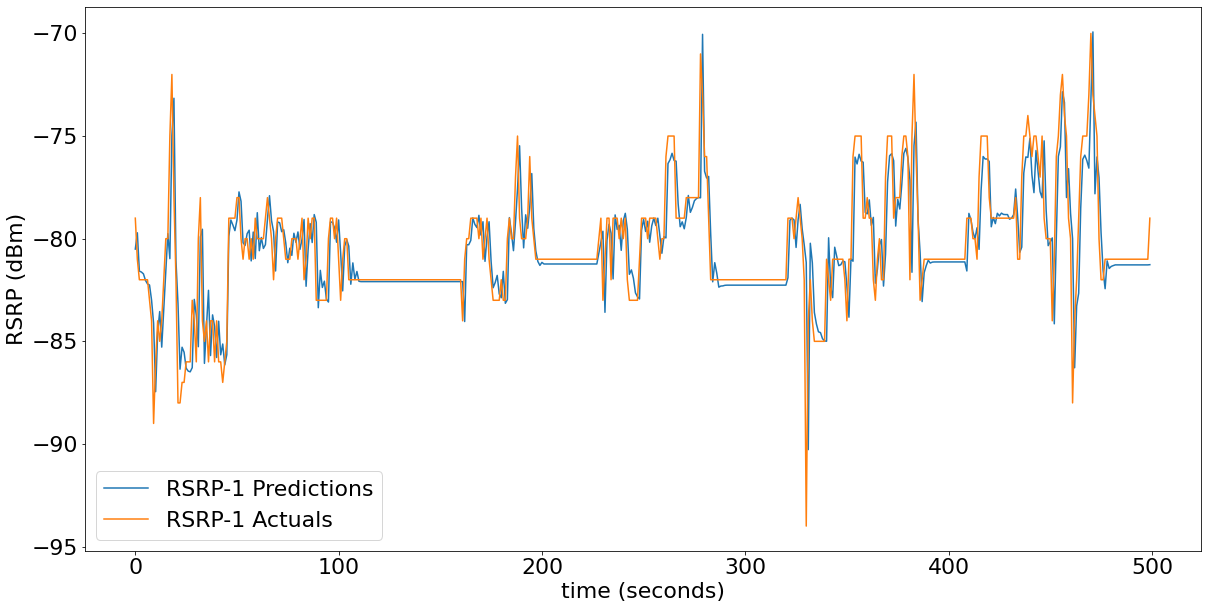

In [18]:
df, RMSE1, RMSE2, MAE1, MAE2 = plot_predictions(model2, X2_test, y2_test)
RMSE = (RMSE1 + RMSE2) / 2
MAE = (MAE1 + MAE2) / 2
df

In [19]:
# model2.save("model2.h5")

# XGBoost - S-PCI binary classification

In [20]:
expanded_preds = np.repeat(model2.predict(X2_test), 2, axis=1)
forecasted_predictions = scaler.inverse_transform(expanded_preds)
forecasted_predictions.shape
# y2_test

(20906, 4)

In [21]:
S_PCI_actual = SPCI_labels[-forecasted_predictions.shape[0]:]
S_PCI_actual.shape

(20906,)

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(forecasted_predictions, S_PCI_actual, test_size = 0.25, random_state = 0)

In [23]:
from sklearn.preprocessing import StandardScaler
sc_class = StandardScaler()
X_train = sc_class.fit_transform(X_train)
X_test = sc_class.transform(X_test)

In [24]:
from xgboost import XGBClassifier
classifier = XGBClassifier(random_state = 0)
classifier.fit(X_train, y_train)
probs_xg_default = classifier.predict_proba(X_test)[:, 1]


C:\Users\shard\anaconda3\envs\irp\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\shard\anaconda3\envs\irp\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:13:37] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
pre_acc = accuracy_score(y_test, y_pred)


[[2314  497]
 [ 312 2104]]


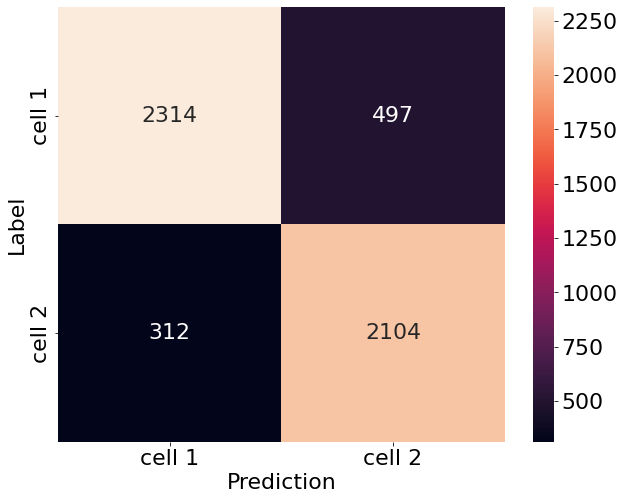

In [26]:
labels = ['cell 1','cell 2']

# confusion_mtx = tf.math.confusion_matrix(y_test, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Hyperparameter tuning via randomised grid search

In [27]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }


In [28]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', silent=True, nthread=1)

In [29]:
folds = 5
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 7)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train, y_train), verbose=3, random_state=7 )

random_search.fit(X_train, y_train)

print('\n Best hyperparameters:')
print(random_search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\shard\anaconda3\envs\irp\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:13:56] WARNING: ..\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:13:56] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Best hyperparameters:
{'subsample': 0.6, 'min_child_weight': 5, 'max_depth': 4, 'gamma': 2, 'colsample_bytree': 0.8}


## Training with tuned hyperparameters

In [30]:
classifier2 = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', silent=True, nthread=1, subsample = 0.6, min_child_weight = 5, max_depth = 4, gamma = 2, colsample_bytree = 0.8, random_state=0)
classifier2.fit(X_train, y_train)
probs_xg = classifier2.predict_proba(X_test)[:, 1]

[20:13:59] WARNING: ..\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:13:59] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## Performance evaluation

### Accuracy, confusion matrix, F1-score

In [31]:
y_pred = classifier2.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

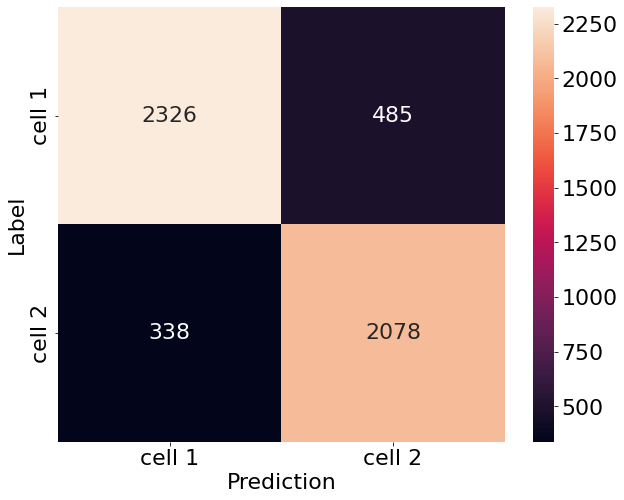

In [32]:
labels = ['cell 1','cell 2']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### ROC curve and AUC

In [33]:

y_test[y_test==1] = 0
y_test[y_test==2] = 1
y_test

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

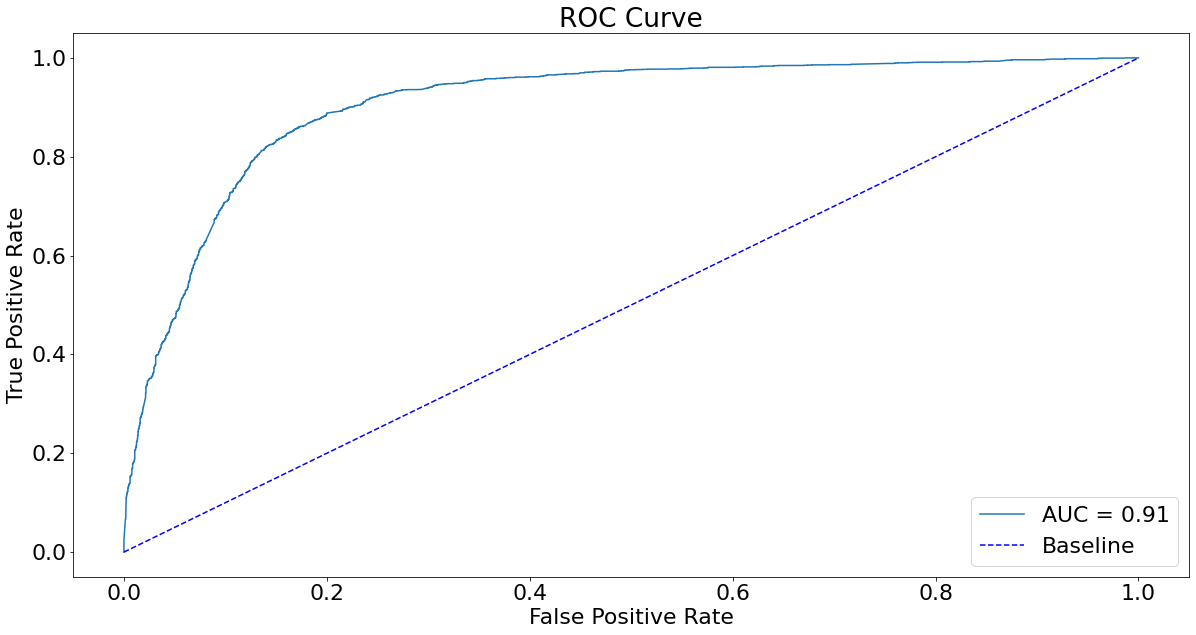

In [34]:
from sklearn.metrics import roc_curve

# y_test_int = y_test

auc_xg = roc_auc_score(y_test, probs_xg)
fpr_xg, tpr_xg, thresholds_xg = roc_curve(y_test, probs_xg)

# plt.figure(figsize=(12, 7))
plt.plot(fpr_xg, tpr_xg, label=f'AUC = {auc_xg:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right");

In [35]:
#print results

print("RMSE:",RMSE)
print("MAE:",MAE)
print("Accuracy:",acc)
print("F1-score:",f1)
print("AUC:",auc_xg)


RMSE: 2.4475842885799235
MAE: 1.2348515895186778
Accuracy: 0.8425483068681844
F1-score: 0.8496803652968036
AUC: 0.9062555217087083
